<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Computer%20Vision/Multiclass_image_classification_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the necessary packages to use in this project

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow

from pathlib import Path
import os.path

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout

from keras.models import Model
import keras.backend as K
from keras.models import Sequential

In [ ]:
train_dir = Path('/content/train')
test_dir = Path('/content/test')
validation_dir = Path('/content/validation')

Get filepath and lebels

In [ ]:
filepaths_train = list(train_dir.glob(r'**/*.jpg'))
filepaths_test = list(test_dir.glob(r'**/*.jpg'))
filepaths_valid = list(validation_dir.glob(r'**/*.jpg'))

In [ ]:
def proc_img(filepath):
  labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

  filepath = pd.Series(filepath, name = 'Filepath').astype(str)
  labels = pd.Series(labels, name = 'Labels')

  df = pd.concat([filepath, labels], axis = 1)

  df = df.sample(frac = 1).reset_index(drop = True)

  return df


train_df = proc_img(filepaths_train)
test_df = proc_img(filepaths_test)
val_df = proc_img(filepaths_valid)

train_df.head()


,Filepath,Labels
0,/content/train/jalepeno/Image_24.jpg,jalepeno
1,/content/train/raddish/Image_90.jpg,raddish
2,/content/train/mango/Image_87.jpg,mango
3,/content/train/jalepeno/Image_50.jpg,jalepeno
4,/content/train/tomato/Image_17.jpg,tomato


In [ ]:
print(f'Number of training pictures: {train_df.shape[0]}')
print(f'Number of training pictures: {test_df.shape[0]}')
print(f'Number of training pictures: {val_df.shape[0]}')

Number of training pictures: 2780
Number of training pictures: 334
Number of training pictures: 334


Display is picture of the dataset with their labels

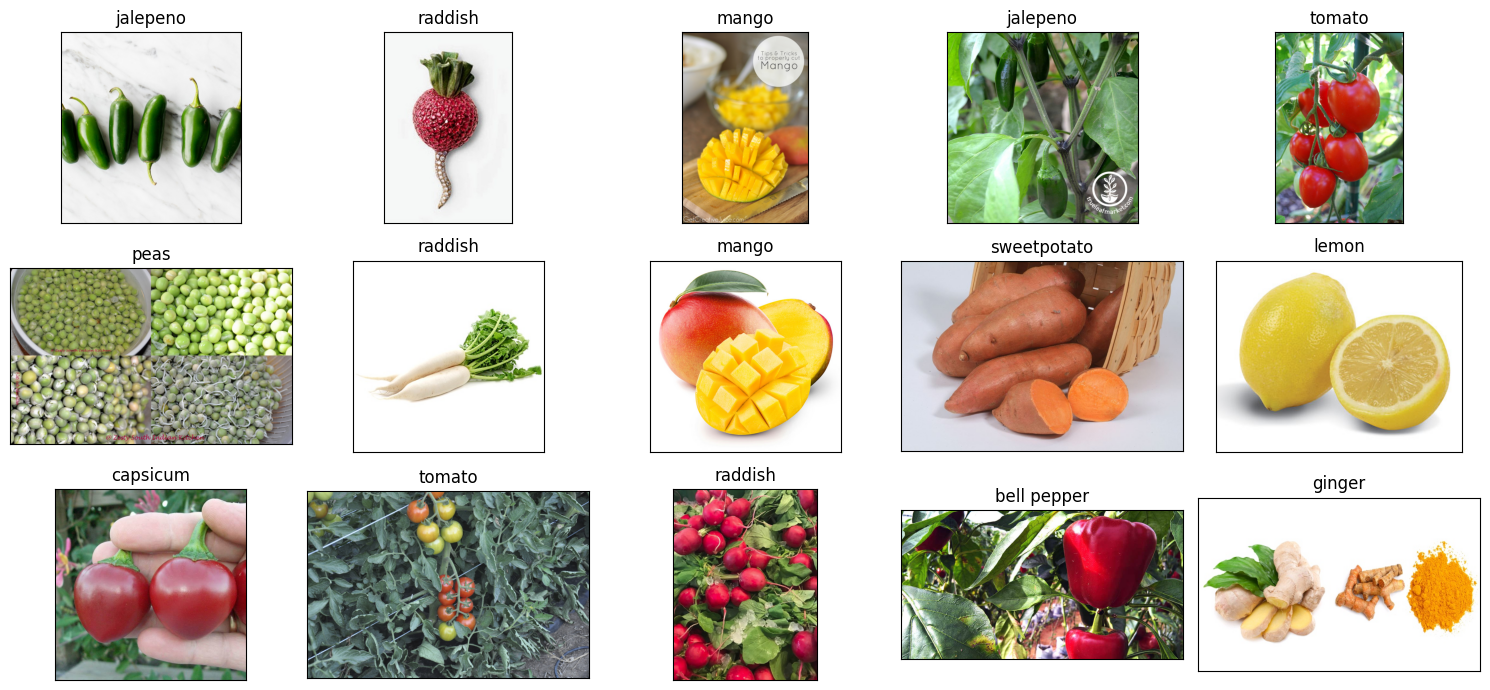

In [ ]:

fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (15, 7),
                        subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(train_df.Filepath[i]))
  ax.set_title(train_df.Labels[i])



plt.tight_layout()
plt.show()

Load the Images

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Labels',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 0,
    #subset = 'training',
    rotation_range = 30,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    heifht_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_images = val_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'Filepath',
    y_col = 'Labels',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 0,
    #subset = 'training',
    rotation_range = 30,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    heifht_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

test_images = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'Filepath',
    y_col = 'Labels',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False
    )

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


Load the pretrained model

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


Train the model

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation = 'relu')(pretrained_model.output)

x = tf.keras.layers.Dense(128, activation = 'relu')(x)

outputs = tf.keras.layers.Dense(36, activation = 'softmax')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)


model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
history = model.fit(train_images, validation_data = val_images, epochs = 10,
                    batch_size = 32, verbose = 1)

Epoch 1/10
87/87 [==============================] - 220s 2s/step - loss: 1.8090 - accuracy: 0.5288 - val_loss: 0.5183 - val_accuracy: 0.8593
Epoch 2/10
87/87 [==============================] - 205s 2s/step - loss: 0.5994 - accuracy: 0.8061 - val_loss: 0.3205 - val_accuracy: 0.9042
Epoch 3/10
87/87 [==============================] - 204s 2s/step - loss: 0.3296 - accuracy: 0.8968 - val_loss: 0.2732 - val_accuracy: 0.9341
Epoch 4/10
87/87 [==============================] - 214s 2s/step - loss: 0.2138 - accuracy: 0.9353 - val_loss: 0.2545 - val_accuracy: 0.9431
Epoch 5/10
87/87 [==============================] - 204s 2s/step - loss: 0.1524 - accuracy: 0.9586 - val_loss: 0.2234 - val_accuracy: 0.9461
Epoch 6/10
87/87 [==============================] - 202s 2s/step - loss: 0.1047 - accuracy: 0.9676 - val_loss: 0.2141 - val_accuracy: 0.9521
Epoch 7/10
87/87 [==============================] - 205s 2s/step - loss: 0.0808 - accuracy: 0.9784 - val_loss: 0.1985 - val_accuracy: 0.9671
Epoch 8/10
87

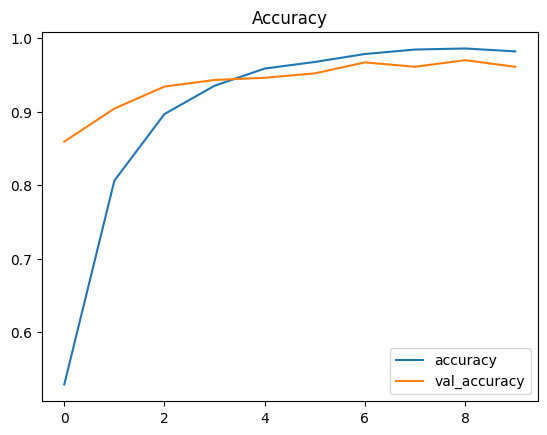

In [ ]:
  pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

  plt.title('Accuracy')
  plt.show()

Visualize the result

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))


Test Loss: 0.20633
Test Accuracy: 96.11%


Predict of the test images

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]


print(f'The first 5 predictions: {pred[:5]}')

11/11 [==============================] - 24s 2s/step
The first 5 predictions: ['sweetcorn', 'lemon', 'corn', 'ginger', 'peas']


Prediction of the some examples

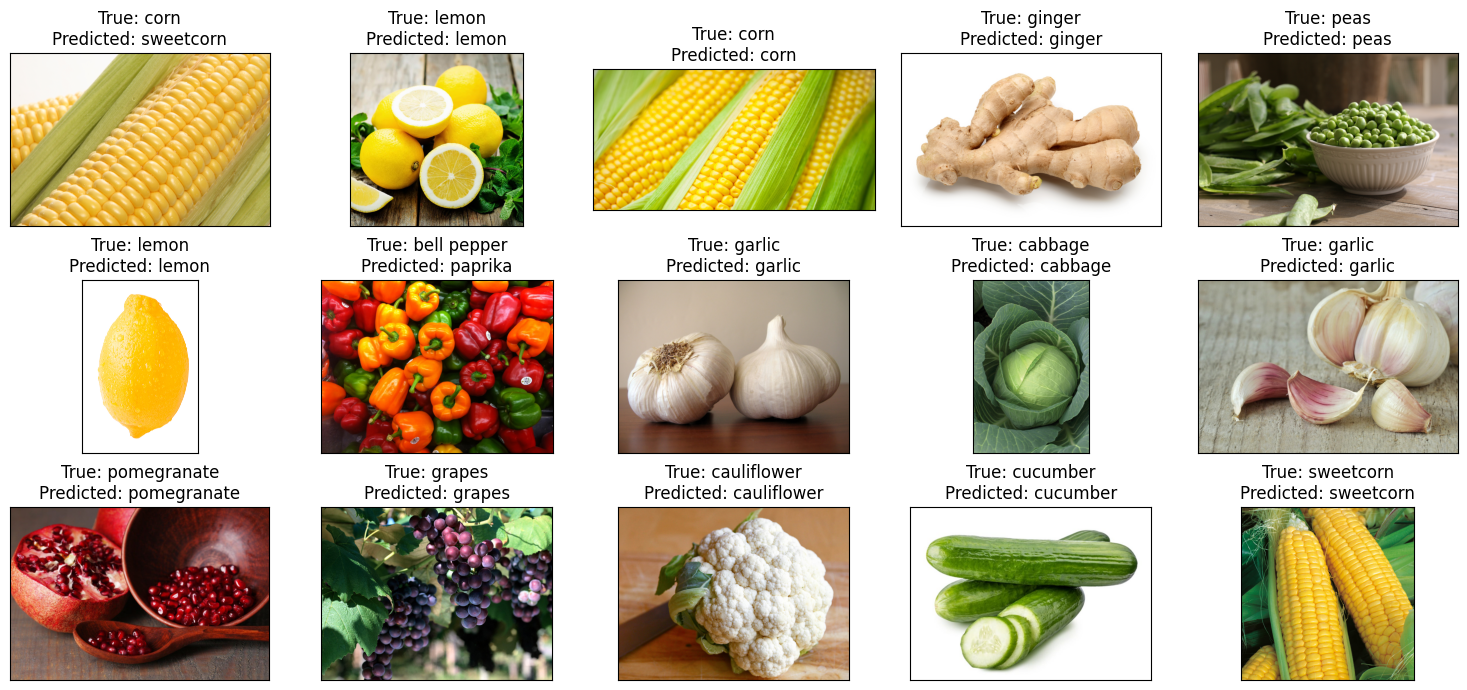

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Labels.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()